### 🤖 Implement ReAct with LangGraph-What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer

In [2]:
import os
from langgraph.prebuilt import create_react_agent
from langchain.agents import Tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, START, END
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
# --------------------------
# 1. Create Retriever Tool
# --------------------------

# Load content from blog
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 50)
chunks = splitter.split_documents(documents=docs)

embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

In [7]:
retriever.invoke("What are autonomous agents")

[Document(id='32225f19-9767-48b1-85e6-47b783025072', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [10]:
def retriever_tool_func(query: str)->str:
    print("Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [12]:
print(retriever_tool_func("What is agents"))

Using RAGRetriever tool
Generative Agents Simulation#
Generative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:
Boiko et

In [14]:
retriever_tool = Tool(
    name = "RAGRetriever",
    description="Use this to fetch relevant knowlegde base info", 
    func = retriever_tool_func
)
retriever_tool
print(retriever_tool.name)

RAGRetriever


In [15]:
#Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'e:\\workspace\\AI_AGENTS_AND_AGENTIC_AI\\venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [16]:
from langchain.chat_models import init_chat_model
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = init_chat_model(model = "gpt-4o-mini")

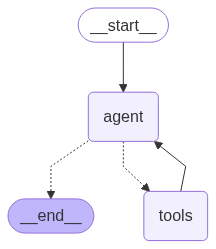

In [18]:
# ----------------------------
# 2. Define the Agent Node
# ----------------------------


tools = [retriever_tool, wiki_tool]

# create the native Langgraph react agent
react_node = create_react_agent(llm, tools)
react_node

In [19]:
# --------------------------
# 3. LangGraph Agent State
# --------------------------
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], add_messages]

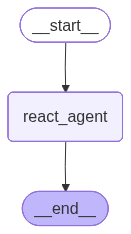

In [21]:
# --------------------------
# 4. Build LangGraph Graph
# --------------------------
builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()
graph

In [22]:
# --------------------------
# 5. Run the ReAct Agent
# --------------------------

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages":[HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n Final Answer:\n", result["messages"][-1].content)

Using RAGRetriever tool

 Final Answer:
 ### Agent Loop

An *agent loop* refers to a process in which an agent learns from its interactions and progressively improves its performance over time. In this context, it involves using past experiences and feedback to refine predictions and actions. For example, in a reinforcement learning scenario, an agent may explore various actions, and based on the outcomes, it adjusts its behavior to enhance future performance. This concept is explored in various spaces, including large language models (LLMs) that can autonomously conduct tasks, such as scientific experiments or problem-solving.

### Autonomous Agents

According to Wikipedia, an *autonomous agent* is an artificial intelligence (AI) system capable of performing complex tasks independently. It perceives its environment, takes actions toward achieving its goals, and may enhance its performance through machine learning or knowledge acquisition.

- **Intelligent Agents**: This broader catego

### Tool creation for RAG agents with langgraph 
To create tools for RAG agents using LangGraph, you're essentially building LLM-invocable functions that your agent can call as part of its reasoning + acting loop (ReAct).

LangGraph uses the Tool abstraction from LangChain and fully supports tools for:

- RAG retrieval
- Search
- Wikipedia
- SQL
- Web APIs
- Calculators, etc.

#### ✅ Tool Design Requirements
A LangGraph tool must:

- Have a name
- Have a description (used by the LLM to decide when to use it)
- Have a callable func, accepting a single input (usually str) and returning str